In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Loading
'''

state = gpd.read_file('Data/Geometry/california.shp')

roads = nice.graph.graph_from_json('Data/atlas.json')
reduced_roads = nice.graph.graph_from_json('Data/reduced_atlas.json')

places_graph = nice.graph.graph_from_json('Data/places_10k.json')

In [3]:
'''
Clustering
'''
deep_reload(nice)

kw = {
    'node_functions': {
        'x': lambda a: np.mean(a),
        'y': lambda a: np.mean(a),
        'population': lambda a: 0
    },
    'edge_functions': {
    },
}

atlas = nice.graph.cluster(reduced_roads, 300, **kw)
atlas = nice.graph.giant_connected_component(atlas)

In [4]:
atlas.number_of_nodes(), atlas.number_of_edges()

(300, 866)

In [6]:
deep_reload(nice)

atlas = nice.graph.route_edges(roads, atlas)

 [--------->] (300/300) 100.00%, 0.68 it/s, 441.46 s elapsed, 0.00 s remaining

In [7]:
atlas.number_of_nodes(), atlas.number_of_edges()

(300, 866)

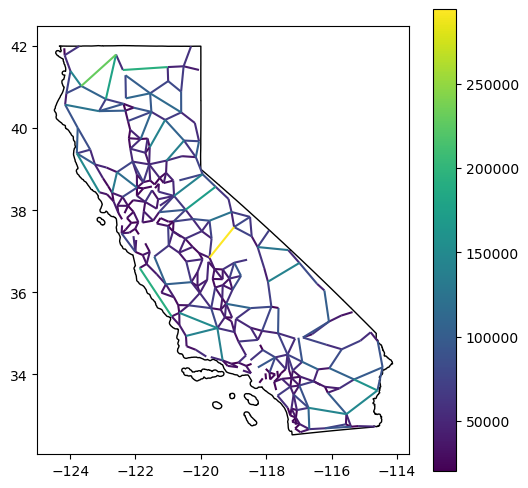

In [16]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)

kw = {
    # 'nodes': {
    #     # 'field': 'population',
    #     # 'colorbar': {},
    #     'plot': {
    #         's': 15,
    #         'ec': 'k',
    #         'lw': .1,
    #     },
    # },
    'edges': {
        'selection': (
            [e for e in atlas.edges if atlas._adj[e[0]][e[1]]['distance'] > 20e3]
        ),
        'field': 'distance',
        'colorbar': {},
        'plot': {
            'zorder': 1,
            'color': 'gray',
        },
    },
}

_ = nice.plot.plot_graph(atlas, ax, **kw)

In [17]:
cc = list(nx.connected_components(atlas))
len(cc), atlas.number_of_nodes()

(1, 300)

In [18]:
nice.graph.graph_to_json(atlas, 'Data/cluster_atlas.json')

In [21]:
'''
Assigning Population
'''

assignment = nice.graph.relate(atlas, places_graph)
lookup = {}

for match in assignment:

    atlas._node[match['id_atlas']]['population'] += (
        places_graph._node[match['id_graph']]['population']
    )

    lookup[match['id_graph']] = match['id_atlas']

# places = [k for k, n in atlas._node.items() if n['population'] >= 1e4]
# stations = [k for k, n in atlas._node.items() if n['population'] < 1e4]

In [22]:
len([k for k, n in atlas._node.items() if n['population'] > 1e4])

180

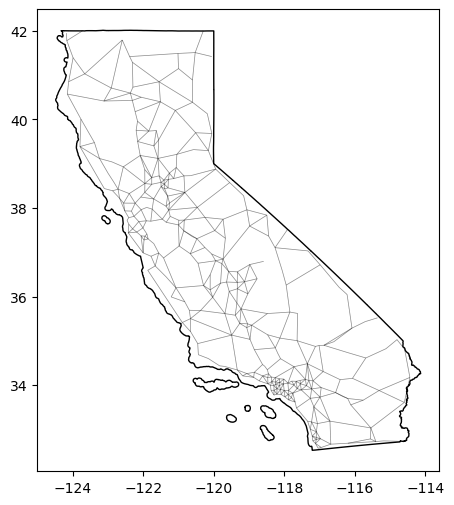

In [23]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)

kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    # 'nodes': {
    #     # 'field': 'population',
    #     # 'colorbar': {},
    #     'plot': {
    #         's': 40,
    #         'ec': 'k',
    #         'lw': .1,
    #     },
    # },
    'edges': {
    'field': 'distance',
    'colorbar': {},
        'plot': {
            'zorder': 1,
            'color': 'gray',
        },
    },
}

# _ = nice.plot.plot_graph(atlas, ax, **kw)

In [24]:
'''
Creating a Vehicle
'''
deep_reload(nice)

kw = {
    'capacity': 75 * 3.6e6,
}

vehicle = nice.optimization.Vehicle(**kw)

atlas = vehicle.energy(atlas)

graph = vehicle.transform(atlas)

In [25]:
wcc = list(nx.weakly_connected_components(graph))
len(wcc), wcc[1:]

(1, [])

In [26]:
graph.number_of_nodes(), graph.number_of_edges()

(300, 45898)

In [32]:
graph._adj[lookup['Fresno, CA']][lookup['Los Angeles, CA']]['distance'] / 1609

246.69981354878806

In [33]:
graph._adj[lookup['Fresno, CA']][lookup['Los Angeles, CA']]['time'] / 3600

4.16284547050172

In [35]:
deep_reload(nice)

practical_range = 75 * 3.6e6 / 550

print(practical_range / 1.609e3)

terminals = [k for k, n in atlas._node.items() if n['population'] >= 1e5]

print(len(terminals))

kw = {
    'terminals': terminals,
    'n_paths': 15,
    'floor': practical_range,
    'objective': 'distance',
    'weight': 'time',
}

paths = nice.graph.get_paths(graph, **kw)

305.1019831628905
89
 [----------->] (89/89) 100.00%, 0.13 it/s, 717.90 s elapsed, 0.00 s remaining

In [36]:
len(paths), len([p for p in paths if len(p['path']) > 2])

(50640, 50593)

In [37]:
paths = [p for p in paths if len(p['path']) > 2]

In [38]:
o = [p['origin'] for p in paths]

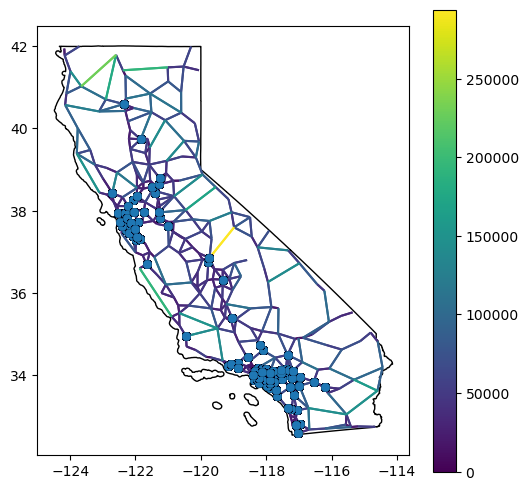

In [39]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'zorder': 0,
    'fc': 'none',
    'ec': 'k',
}

state.plot(ax = ax, **kw)

kw = {
    'plot': {
        'zorder': 1,
        'color': 'k',
        'lw': .5,
        'alpha': .25,
    },
}

_ = nice.plot.plot_edges(atlas, ax, **kw)

kw = {
    'nodes': {
        # 'field': 'population',
        'selection': o,
        # 'colorbar': {},
        'plot': {
            's': 40,
            'ec': 'k',
            'lw': .1,
        },
    },
    'edges': {
    'field': 'distance',
    'colorbar': {},
        'plot': {
            'zorder': 1,
            'color': 'gray',
        },
    },
}

_ = nice.plot.plot_graph(atlas, ax, **kw)

In [40]:
75 * 3.6e6 / 550 / 1609

305.1019831628905

In [41]:
137 * 3.6e3 / 1e3

493.2

In [42]:
deep_reload(nice)

nice.graph.graph_to_json(graph, 'Data/cluster_graph.json')
nice.utilities.to_json(paths, 'Data/cluster_paths.json')

In [220]:
deep_reload(nice)

graph = nice.graph.graph_from_json('Data/cluster_graph.json')
paths = nice.utilities.from_json('Data/cluster_paths.json')

In [221]:
graph.number_of_nodes(), graph.number_of_edges()

(300, 45898)

In [223]:
'''
Adding places
'''

place_nodes = [k for k, n in atlas._node.items() if n['population'] >= 1e4]
stations = list(graph.nodes)

nodes = [(k, v) for k, v in graph._node.items()]
edges = []
places = []

mapping = {}
mapping_r = {}

k = 0

for place_node in place_nodes:

    handle = f'place_{k}'
    k += 1

    mapping[place_node] = handle
    mapping_r[handle] = place_node
    places.append(handle)

    nodes.append((handle, {**graph._node[place_node]}))

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge = {k: v for k, v in edge.items() if k != 'path'}
        
        s = mapping.get(source, source)
        t = mapping.get(target, target)

        edges.append((source, target, edge))
        edges.append((source, t, edge))
        edges.append((s, target, edge))
        edges.append((s, t, edge))

g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [224]:
g.number_of_nodes(), g.number_of_edges()

(480, 122254)

In [225]:
graph = g

In [226]:
for path in paths:

    path['origin'] = mapping[path['origin']]
    path['destination'] = mapping[path['destination']]

    path['path'][0] = mapping[path['path'][0]]
    path['path'][-1] = mapping[path['path'][-1]]

In [227]:
'''
Setting travel demand
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    # 'remove_function': lambda x: nice.demand.within_range(x, 75 * 3.6e6 * 0),
}

graph = nice.demand.demand(graph, places, **kw)

In [228]:
min_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['free_flow'].items():

            min_cost += cost * node['flows'][target]

max_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['mode_switch'].items():

            max_cost += cost * node['flows'][target]

min_cost / 3600, max_cost / 3600

(2.1403769336801677, 6.066690984897929)

In [229]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))

# delta = 5

for station in stations:

    node = graph._node[station]

    power = power
    m = 1 / (energy / power)
    n = rng.integers(0, 10)
    lower_bound = n
    upper_bound = n
    c = list(range(lower_bound, upper_bound + 1))
    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])
    # expenditure[expenditure > 0] = expenditure[expenditure > 0] * 1.25

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays)
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure

In [230]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 2.458440065383911
Sets Built: 0.05758309364318848
Parameters Built: 0.9087178707122803
Variables Built: 2.6201438903808594
Constraints Built: 1.2948362827301025
Expenditure Built: 0.026203155517578125
Objective Built: 1.0692017078399658


In [231]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 10 * 60,
    },
}

scale = 1e4 / 3600

network.model.scale = scale
network.model.penalty = 1
# network.model.expenditure = 100
# network.model.expenditure_cost = 0

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value)

Problem Solved: 4.5635340213775635
Results Collected: 0.780519962310791
Objective Value: 57385.713410119606


In [232]:
graph._node[stations[6]]

{'x': -121.77816887997419,
 'y': 36.909280399992085,
 'population': 51438.0,
 'cost': 650270.0,
 'power': 80000.0,
 'volumes': array([[0.        , 0.00203175, 0.00205714, 0.0020812 , 0.00210526,
         0.00212932, 0.00215338, 0.00217744, 0.0022015 , 0.00222556,
         0.00224962, 0.00227368, 0.00229774, 0.0023218 , 0.00234586,
         0.00236992, 0.00239398, 0.00241805, 0.00244211, 0.00246617,
         0.00249023, 0.00251429]]),
 'delays': array([[0.00000000e+00, 5.69170709e+00, 6.86397981e+00, 8.22853852e+00,
         9.90758731e+00, 1.19893946e+01, 1.45930305e+01, 1.78817186e+01,
         2.20833128e+01, 2.75225482e+01, 3.46733812e+01, 4.42469336e+01,
         5.73453309e+01, 7.57438913e+01, 1.02439007e+02, 1.42788194e+02,
         2.07096898e+02, 3.17181219e+02, 5.25718294e+02, 9.87039953e+02,
         2.32262074e+03, 9.37268193e+03]]),
 'counts': array([4]),
 'expenditures': array([0]),
 '_class': nice.optimization.station.Station}

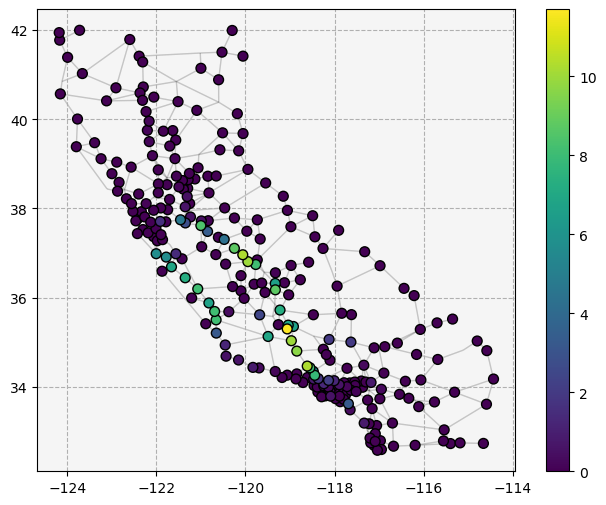

In [236]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)
    # node['optimal_ports'] = node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['selection'] > 0]
        ),
        # 'selection': stations,
        'field': 'delay',
        # 'field': 'utilization',
        # 'field': 'delta',
        # 'field': 'selection',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

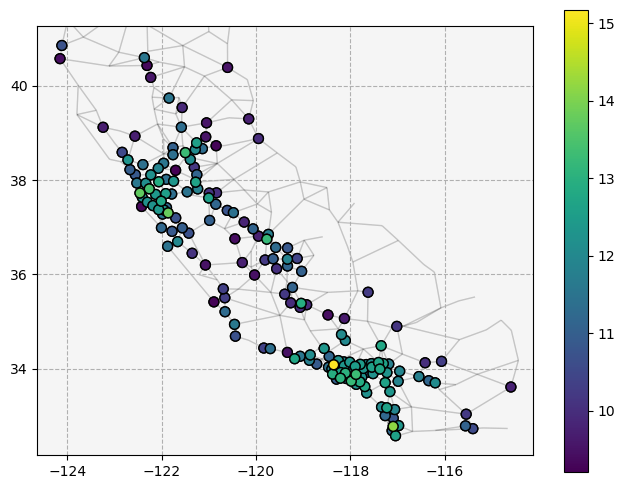

In [244]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in graph._node.items():

    node['log_population'] = np.log(node.get('population', 1))

kw = {
    'nodes': {
        'field': 'log_population',
        # 'selection': [k for k, n in graph._node.items() if n['log_population'] > 0],
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(graph, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')